In [23]:
!pip install miditok
!pip install tokenizers
!pip install transformers
!pip install pretty_midi
!pip install librosa

import tensorflow as tf
from tensorflow import keras
import numpy
import miditok
import tqdm
from miditok import MIDILike, MIDITokenizer, OctupleMono, REMI
import pathlib
from miditok.constants import CHORD_MAPS
from transformers import TFGPT2LMHeadModel, GPT2Config, Trainer, TrainingArguments, GenerationConfig, pipeline
from miditoolkit import MidiFile
from pathlib import Path
import pretty_midi
import librosa.display
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
pitch_range = range(21, 109)
beat_res = {(0, 4): 8, (4, 12): 4}
nb_velocities = 32
additional_tokens = {'Chord': True, 'Rest': True, 'Tempo': True,
                     'rest_range': (2, 8),  # (half, 8 beats)
                     'nb_tempos': 32,  # nb of tempo bins
                     'tempo_range': (40, 250),  # (min, max)
                     'Program': False,
                     "chord_maps": CHORD_MAPS,
                     "chord_tokens_with_root_note": True,
                     "chord_unknown": False}
special_tokens = ["PAD", "BOS", "EOS"]

#creates tokenizer
tokenizer = REMI(params = '/content/gdrive/MyDrive/ala/REMI/tokens_noBPE/config.txt')

In [4]:
# Creates model
config = GPT2Config( 
    vocab_size=1000,
    n_positions=10,
    n_embd=64,
    n_layer=4,
    n_head=4,
    n_inner=128,
    resid_pdrop=.1,
    embd_pdrop=.1,
    attn_pdrop=.1,
    pad_token_id=tokenizer['PAD_None'],
    bos_token_id=tokenizer['BOS_None'],
    eos_token_id=tokenizer['EOS_None'],
)
model = TFGPT2LMHeadModel(config)   

In [5]:
model_path = "/content/gdrive/MyDrive/model_f/REMI_model_1/"


model.from_pretrained(model_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/gdrive/MyDrive/model_f/REMI_model_1/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [6]:
# defining our optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])

In [7]:
tokenizer.learn_bpe(
    vocab_size=1000,
    tokens_paths=list(Path("/content/gdrive/MyDrive/ala/REMI/tokens_noBPE").glob('**/*.json')),
    out_dir=Path('/content/gdrive/MyDrive/ala/REMI/tokens_BPE'),
)

Loading token files: 100%|██████████| 6872/6872 [02:16<00:00, 50.25it/s] 


In [25]:
midi_path = '/content/gdrive/MyDrive/ala/REMI/test_midi/1.mid' #@param {type:"string"}

midi = MidiFile(midi_path)
token = tokenizer(midi)  # automatically detects MidiFile, paths or tokens before converting them
print('token:', token)
print('token ids:', token[0].ids)

prompt = [token[0].ids]


token: [TokSequence(tokens=['Bar_None', 'Position_0', 'Tempo_134', 'Pitch_53', 'Velocity_127', 'Duration_1.4.8', 'Pitch_60', 'Velocity_127', 'Duration_0.2.8', 'Position_4', 'Tempo_134', 'Pitch_68', 'Velocity_127', 'Duration_0.4.8', 'Position_8', 'Tempo_134', 'Pitch_65', 'Velocity_127', 'Duration_0.4.8', 'Position_12', 'Tempo_134', 'Pitch_56', 'Velocity_127', 'Duration_1.4.8', 'Pitch_63', 'Velocity_127', 'Duration_0.2.8', 'Pitch_65', 'Velocity_127', 'Duration_0.2.8', 'Position_16', 'Tempo_134', 'Pitch_63', 'Velocity_127', 'Duration_0.4.8', 'Position_20', 'Tempo_134', 'Pitch_60', 'Velocity_127', 'Duration_0.4.8', 'Position_24', 'Tempo_134', 'Pitch_49', 'Velocity_127', 'Duration_2.0.8', 'Pitch_60', 'Velocity_127', 'Duration_0.4.8', 'Pitch_61', 'Velocity_127', 'Duration_0.4.8', 'Position_28', 'Tempo_134', 'Pitch_60', 'Velocity_127', 'Duration_1.4.8', 'Bar_None', 'Position_8', 'Tempo_134', 'Pitch_48', 'Velocity_127', 'Duration_1.4.8', 'Position_20', 'Tempo_134', 'Pitch_49', 'Velocity_127', 

In [27]:


generation_config = GenerationConfig(
    max_new_tokens=512 #@param {type:"slider", min:32, max:1024, step:4}
    , num_beams=1,        # no beam search
    do_sample=True,     # but sample instead
    temperature=0.98 #@param {type:"slider", min:0.7, max:0.99, step:0.01}
    , top_k=15,
    top_p=0.95,
    epsilon_cutoff=3e-4,
    eta_cutoff=1e-3,
)

In [28]:
outputs = model.generate(prompt, generation_config)

In [29]:
outputs = tf.Variable(outputs).numpy().tolist()
print('old token:', token[0].ids)

new_data = token
new_data[0].ids = outputs

print('new token:', new_data[0].ids)

old token: [341, 36, 327, 43, 304, 445, 938, 396, 950, 407, 39, 327, 46, 304, 48, 304, 354, 46, 298, 432, 935, 349, 32, 342, 935, 44, 298, 395, 43, 327, 3, 396, 31, 327, 432, 32, 327, 349, 43, 304, 896, 44, 304, 395, 43, 304, 341, 36, 327, 43, 304, 445, 938, 396, 950, 407, 39, 327, 46, 304, 48, 304, 354, 46, 298, 432, 935, 349, 32, 342, 935, 44, 298, 395, 43, 327, 3, 396, 31, 327, 432, 32, 327, 349, 43, 304, 896, 44, 304, 395, 43, 304]
new token: [[341, 36, 327, 43, 304, 445, 938, 396, 950, 407, 39, 327, 46, 304, 48, 304, 354, 46, 298, 432, 935, 349, 32, 342, 935, 44, 298, 395, 43, 327, 3, 396, 31, 327, 432, 32, 327, 349, 43, 304, 896, 44, 304, 395, 43, 304, 341, 36, 327, 43, 304, 445, 938, 396, 950, 407, 39, 327, 46, 304, 48, 304, 354, 46, 298, 432, 935, 349, 32, 342, 935, 44, 298, 395, 43, 327, 3, 396, 31, 327, 432, 32, 327, 349, 43, 304, 896, 44, 304, 395, 43, 304, 789, 833, 249, 318, 172, 138, 204, 547, 547, 204, 547, 113, 412, 986, 835, 491, 582, 150, 584, 543, 192, 451, 451, 612,

In [30]:
generated_midi_filepath = '/content/gdrive/MyDrive/ala/REMI/generated_midi/2.mid' #@param {type:"string"}

generated_midi = tokenizer(new_data[0].ids)
generated_midi.dump(generated_midi_filepath)

In [16]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

<ipython-input-16-23356387cf61>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


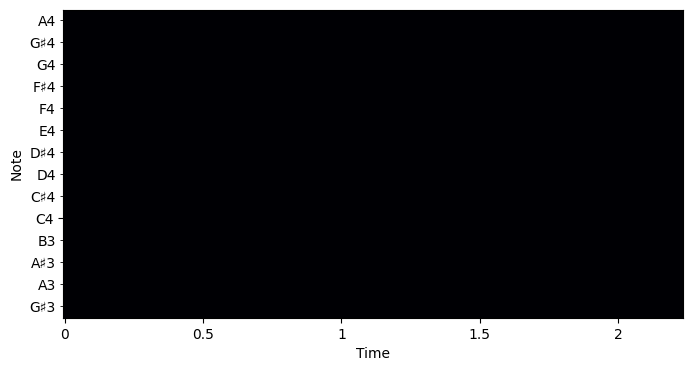

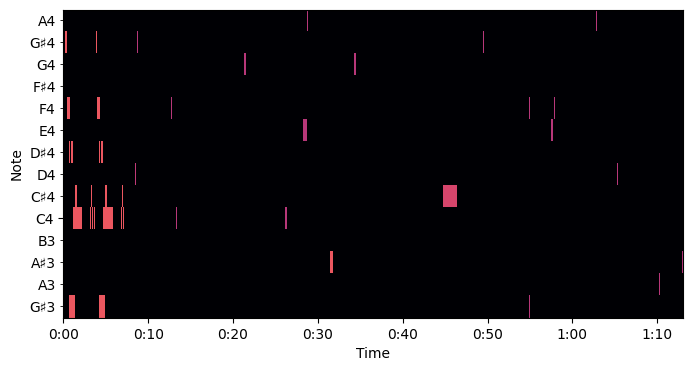

In [32]:
pm = PrettyMIDI("/content/gdrive/MyDrive/dummy/test midi/1.mid")

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 56, 70)

pm1 = PrettyMIDI("/content/gdrive/MyDrive/ala/REMI/generated_midi/2.mid")

plt.figure(figsize=(8, 4))
plot_piano_roll(pm1, 56, 70)